In [1]:
import pandas as pd

df = pd.read_csv("./data/penguins.csv")
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [2]:
from sklearn.preprocessing import MinMaxScaler 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

def load_penguin_dataset():
    df = pd.read_csv("./data/penguins.csv")
    df = df.dropna(subset="body_mass_g")
    sex_mapping = {'MALE': 1, 'FEMALE': 0}
    df['sex'] = df['sex'].map(sex_mapping)
    df['sex'] = df['sex'].fillna(-1)
    spec_mapping = {'Gentoo': 2, 'Adelie': 1, 'Chinstrap': 0}
    df['species'] = df['species'].map(spec_mapping)
    df['species'] = df['species'].fillna(-1)
    X = df.drop(["body_mass_g"], axis=1)
    y = df["body_mass_g"]
    return train_test_split(X, y, train_size=0.8, random_state=1234) 
x_train, x_test, y_train, y_test = load_penguin_dataset()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32516\3761855993.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x_train.corr(),


<Axes: >

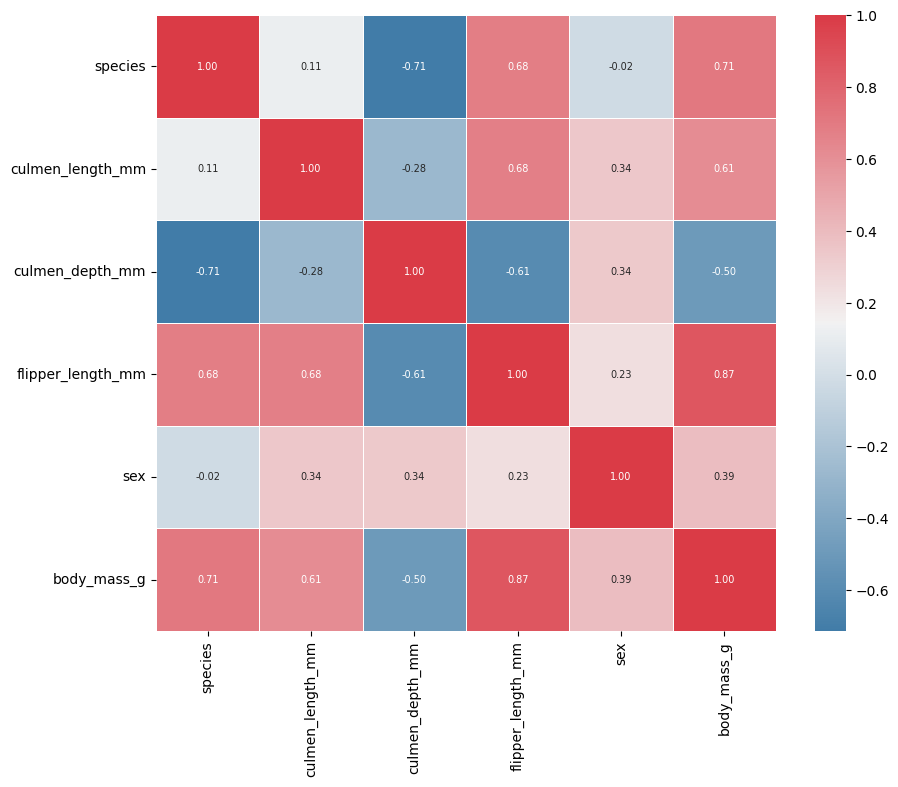

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

x_train["body_mass_g"] = y_train
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(
    x_train.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap=cmap, 
    linewidths=.5, 
    annot_kws={"size": 7}
)

In [4]:
minmax_scaler = MinMaxScaler()
df = df[["flipper_length_mm", "body_mass_g"]]
df[["flipper_length_mm", "body_mass_g"]] = minmax_scaler.fit_transform(df)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32516\496426362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["flipper_length_mm", "body_mass_g"]] = minmax_scaler.fit_transform(df)


In [5]:
df.isna().sum()
df = df.dropna()

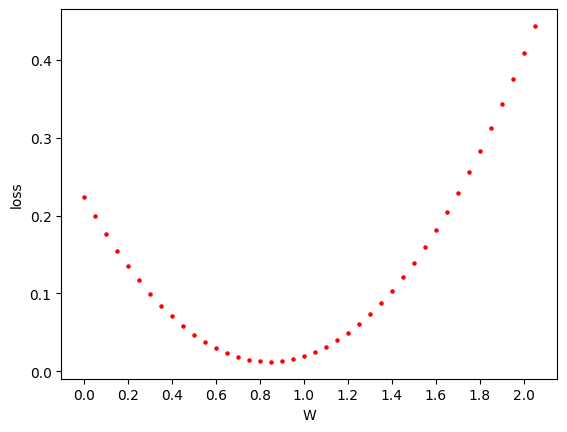

In [6]:
def loss_function(w):
    return ((df["flipper_length_mm"] * w - df["body_mass_g"]) ** 2).sum() / len(df)

losses = []
w_candidates = np.arange(0, 2.1, 0.05)
for w_candidate in w_candidates:
    losses.append(loss_function(w_candidate))

plt.scatter(w_candidates, losses, s=5, color="red")
_ = plt.xticks(np.arange(0, 2.1, 0.2))
plt.xlabel("W")
plt.ylabel("loss")

def plot_line(w, bias, color):
    x = np.linspace(0, 1, 100)
    y = w * x + bias 
    plt.plot(x, y, color=color, label=f"w={w}")

Text(0, 0.5, 'scaled price')

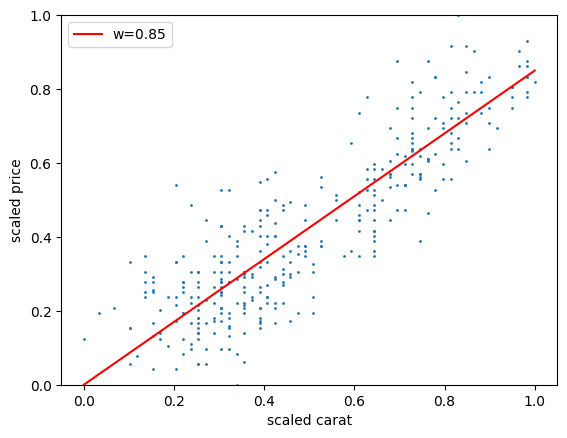

In [7]:
plt.scatter(df["flipper_length_mm"], df["body_mass_g"], s=1)
plot_line(0.85, 0, "red")
plt.legend()
plt.ylim(0, 1)
plt.xlabel("scaled carat")
plt.ylabel("scaled price")

In [8]:
import torch

class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

model = LinearRegression(input_dim=1, output_dim=1)
learning_rate = 0.3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss() 
epochs = 100

inputs = torch.Tensor(df[["flipper_length_mm"]].values)
labels = torch.Tensor(df[["body_mass_g"]].values)

losses = []
lines = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # 현재 모델을 이용해서 예측값 계산
    outputs = model(inputs)
    # 오차 계산
    loss = criterion(outputs, labels)
    # 편미분 수행 
    loss.backward()
    
    # learning rate만큼 모델 파라미터 업데이트
    optimizer.step()
    losses.append(loss.item())
    weight = model.linear.weight[0].item()
    bias = model.linear.bias[0].item()
    if (epoch + 1) % 10 == 0:
        lines.append((weight, bias))
        print('epoch {}, loss {}'.format(epoch+1, loss.item()))

epoch 10, loss 0.06616034358739853
epoch 20, loss 0.04319905862212181
epoch 30, loss 0.029958730563521385
epoch 40, loss 0.022323859855532646
epoch 50, loss 0.017921311780810356
epoch 60, loss 0.015382638201117516
epoch 70, loss 0.013918745331466198
epoch 80, loss 0.013074608519673347
epoch 90, loss 0.012587848119437695
epoch 100, loss 0.012307164259254932


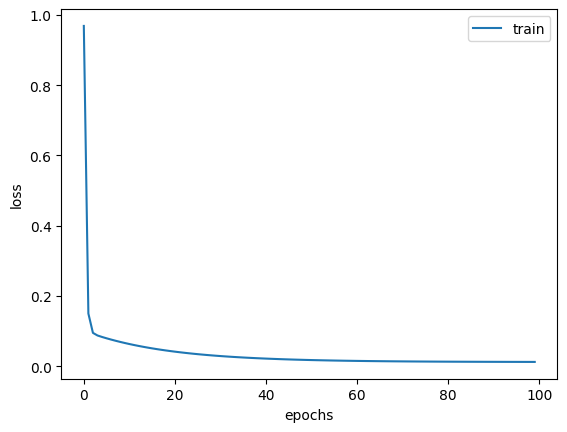

In [9]:
plt.plot(losses, label="train")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

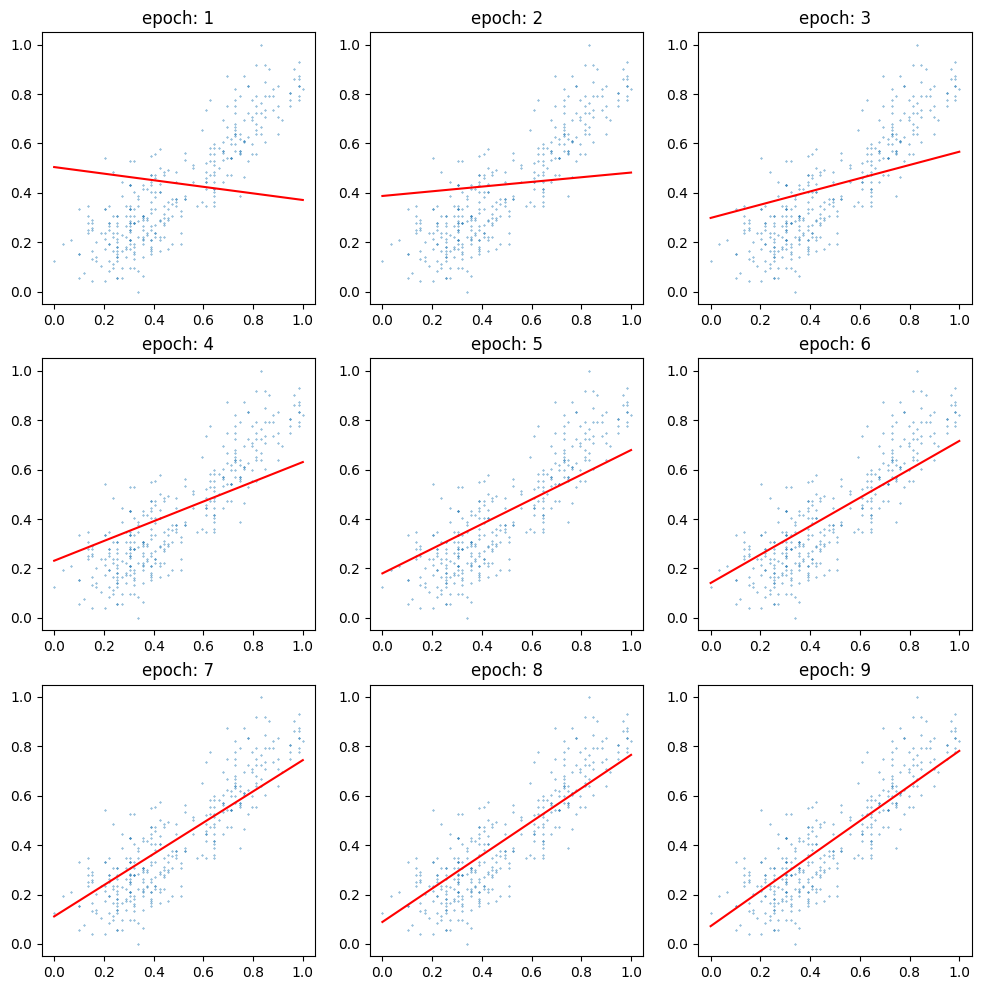

In [10]:
figure = plt.figure(figsize=(12, 12))
axs = []
for i in range(9):
    ax = figure.add_subplot(3, 3, i+1)
    w, bias = lines[i]
    x = np.linspace(0, 1, 100)
    y = w * x + bias 
    ax.scatter(df["flipper_length_mm"], df["body_mass_g"], s=0.1)
    ax.plot(x, y, color="red", label=f"w={w}")
    ax.set_title(f"epoch: {i+1}")